In [1]:
import os
import numpy as np
import requests
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import json
from copy import deepcopy


from matplotlib import rc
import matplotlib.ticker as tick

import sys
sys.path.insert(0, '../..')
from RB_ZTF.scripts.rnn import *
from RB_ZTF.scripts.datasets import *

from torch.utils.data import DataLoader, random_split
from sklearn import metrics

set_random_seed(7)

In [2]:
oids, labels = get_only_r_oids('../akb.ztf.snad.space.json')
data = EmbsSequenceData(oids, labels, label_type='float', path='../embeddings/')

fold1, fold2, fold3, fold4, fold5 = random_split(data, [0.2, 0.2, 0.2, 0.2, 0.2])
folds = [fold1, fold2, fold3, fold4, fold5]

In [3]:
#output, labels = [], []
def get_result_kfold(model, model_name):
    result = {'roc_auc':[], 'tpr':[], 'fpr':[], 'f1':[],
              'thresholds':[], 'precision':[], 'recall':[],
              'accuracy':[]}
    bucket_boundaries = [200, 400, 600, 800]
    for k, fold in enumerate(folds):
    #concat_folds = ConcatDataset(folds[:k] + folds[k+1:])
    #train_sampler = BySequenceLengthSampler(concat_folds, bucket_boundaries, 32, drop_last=False, shuffle=True)
        test_sampler = BySequenceLengthSampler(fold, bucket_boundaries, 32, drop_last=False, shuffle=False)


    #train_loader = DataLoader(concat_folds, batch_size=1, 
    #                    batch_sampler=train_sampler, 
    #                    num_workers=16,
    #                    collate_fn=collate,
    #                    drop_last=False, pin_memory=False)

        test_loader = DataLoader(fold, batch_size=1, 
                        batch_sampler=test_sampler, 
                        num_workers=4,
                        collate_fn=collate,
                        drop_last=False, pin_memory=False)
        
        model.load_state_dict(torch.load(f'../trained_models/rnn/{model_name}/model{k}.zip'))
        model.eval()
        if model.out_size == 2:
            out, gt, _ = get_pred(model, test_loader)
        else:
            out, gt = get_pred(model, test_loader)
        fpr, tpr, thresholds = metrics.roc_curve(gt, out)
        result['tpr'].append(tpr)
        result['fpr'].append(fpr)
        result['thresholds'].append(thresholds)
        result['roc_auc'].append(metrics.roc_auc_score(gt, out))
        f1scores = []
        for tr in thresholds:
            current_predict = (out >=tr).long()
            f1scores.append(metrics.f1_score(gt, current_predict))
        #result['f1'].append(f1scores)
        result['f1'].append(np.max(f1scores))
        ind = np.argmax(f1scores)
        cur_best_thr = result['thresholds'][-1][ind] #best thresholds for i fold
        result['precision'].append(metrics.precision_score(gt, (out >= cur_best_thr).long()))
        result['recall'].append(metrics.recall_score(gt, (out >= cur_best_thr).long()))
        result['accuracy'].append(metrics.accuracy_score(gt, (out >= cur_best_thr).long()))
    return result

# Model result metrics

In [4]:
models_args = {'baseline': {'model':{'rnn_type': 'GRU'}},
        'wd_2dir': {'model':{'rnn_type': 'GRU', 'bidirectional': True,}},
        'tversky': {'model':{'rnn_type': 'GRU'}},
        'lstm': {'model':{'rnn_type': 'LSTM'}}
       }

In [5]:
fprs, tprs = [], []

for name, args in models_args.items():
    model = RBclassifier(hidden_size=128, latent_dim=36, out_size=2, **args['model'])
    results = get_result_kfold(model, name)
    fprs.append(results['fpr'][0])
    tprs.append(results['tpr'][0])

    print(f'{name} model')
    print('-------------ROC AUC-------------')
    print(f"{np.mean(results['roc_auc']):.2f} +- {np.std(results['roc_auc']):.2f}")
    

    print('-------------Accuracy-------------')
    print(f"{np.mean(results['accuracy']):.2f} +- {np.std(results['accuracy']):.2f}")

    
    print('-------------F1-score-------------')
    print(f"{np.mean(results['f1']):.2f} +- {np.std(results['f1']):.2f}\n\n")



baseline model
-------------ROC AUC-------------
0.84 +- 0.01
-------------Accuracy-------------
0.78 +- 0.02
-------------F1-score-------------
0.79 +- 0.01


wd_2dir model
-------------ROC AUC-------------
0.86 +- 0.01
-------------Accuracy-------------
0.80 +- 0.02
-------------F1-score-------------
0.80 +- 0.01


tversky model
-------------ROC AUC-------------
0.84 +- 0.02
-------------Accuracy-------------
0.79 +- 0.02
-------------F1-score-------------
0.79 +- 0.02


lstm model
-------------ROC AUC-------------
0.76 +- 0.04
-------------Accuracy-------------
0.76 +- 0.03
-------------F1-score-------------
0.77 +- 0.02




# ROC plot

In [6]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=8, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=5, width=1.5)

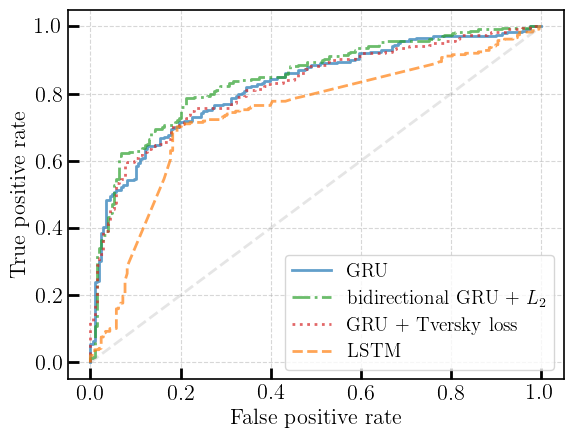

In [9]:
labels = ['GRU', r'bidirectional GRU $+~L_2$', r'GRU $+$ Tversky loss',  'LSTM']
lss = ['-', '-.', ':', '--']
cols = [u'#1f77b4', u'#2ca02c', u'#d62728', u'#ff7f0e']

fig, ax = plt.subplots()
presets_fig(ax)
ax.grid('on', linestyle='--', alpha=0.5)

for i in range(4):
    plt.plot(fprs[i], tprs[i], label=labels[i], alpha=0.7, ls=lss[i], c=cols[i])

plt.plot([0, 1], [0, 1], ls='--', alpha=0.2, c='gray')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend(fontsize=14)
#plt.savefig('visualizations/roc.pdf', dpi=400, format='pdf')